This jupiter notebook is designed to evaluate the hysteresis observed in the UDIP-4 data. The idea is to numerically integrate the area between the two IV curves, then compare that to the rectangle encompassing the entire electron saturation region.

In [2]:
import numpy as np
import RockSat_json.RockSat_json 
import fitting.RockSat_1_14_fitting_functions as R_fitting
import pckt
from fitting import fit
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['text.usetex']=True

In [3]:
packets = RockSat_json.RockSat_json.import_data(f"C:/Users/carso/OneDrive/Documents/DAPPEr/Github/DAPPEr/Data/UDIP_4_800s.json")
#packet = pckt("Data/UDIP_4_800s.json")

The next two cells highlight which indices of the full and dense sweeps were selected for the integration

1.7595451656404557


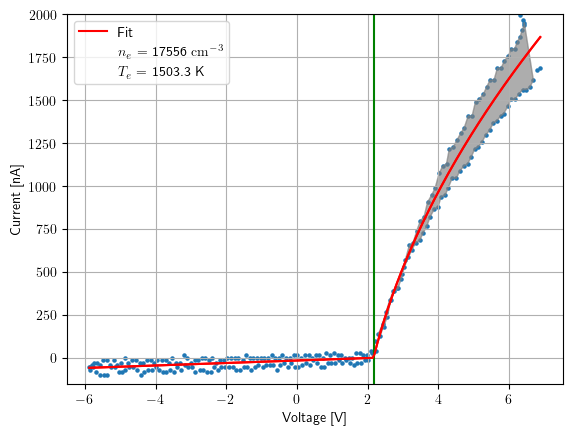

In [4]:
f_high_start = 8
f_high_stop = 51
f_low_start = 211
f_low_stop = 254
b = 300
# rect = patches.Rectangle((2, -35), 5, 2050, edgecolor='1', facecolor='.7', linewidth=2, alpha = .3)
# plt.gca().add_patch(rect)
V= packets['packets']['Full'][f'{b}']['Voltage']
I = np.array(packets['packets']['Full'][f'{b}']['Current0']) * -1.e9
fitx,fity,popt,_ = fit.gen_fit(V[6:],I[6:])
plt.plot(fitx,fity, c = "r")
plt.legend([r"Fit"])
plt.scatter(V[6:],I[6:], s=5)
plt.ylim((-150,2000))
Vs = np.concat([V[f_high_start:f_high_stop], V[f_low_start:f_low_stop]])
Is = np.concat([I[f_high_start:f_high_stop], I[f_low_start:f_low_stop]])
vertices = np.column_stack([Vs, Is])
polygon = patches.Polygon(vertices, closed=True, color='gray', alpha=0.4, label='Polygon between curves')
plt.gca().add_patch(polygon)
fitx,fity,popt,_ = fit.gen_fit(V[6:],I[6:])
plt.vlines([popt[1]], [-150], [2000], colors = "g")
line_fit, = plt.plot(fitx, fity, c="r", label="Fit")
param1 = patches.Patch(color='none', label= r"$n_e$ = " + str(popt[4] /1e6)[0:5] +r"${~\rm cm}^{-3}$")
param2 = patches.Patch(color='none', label=fr"$T_e$ = {popt[5]:.1f} K")

# Add the polygon patch to the axis
plt.gca().add_patch(polygon)

# Combine all legend handles
plt.legend(handles=[line_fit, param1, param2])
# plt.scatter(packets['packets']['Full'][f'{b}']['Voltage'][f_high_start:f_high_stop],
#              np.array(packets['packets']['Full'][f'{b}']['Current0'][f_high_start:f_high_stop]) * -1.e9, marker = 'x')
# plt.scatter(packets['packets']['Full'][f'{b}']['Voltage'][f_low_start:f_low_stop],
#              np.array(packets['packets']['Full'][f'{b}']['Current0'][f_low_start:f_low_stop]) * -1.e9, marker='x')
plt.xlabel(r"Voltage [V]")
plt.ylabel(r"Current [nA]")
plt.grid(True)
plt.savefig(r"sample_IV_curve.png")
print(popt[0])

Text(0, 0.5, 'Current [nA]')

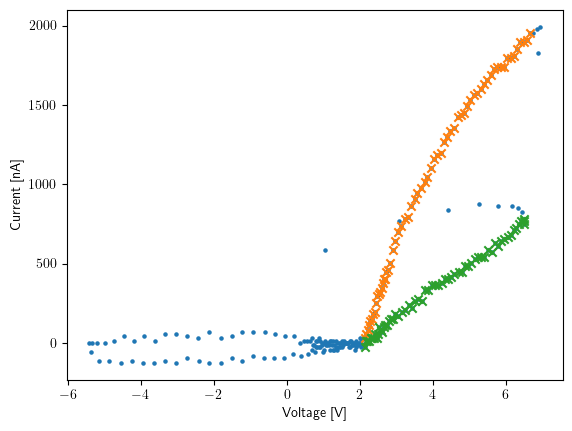

In [4]:
d_low_start = 8
d_low_stop = 70
d_high_start = 190
d_high_stop = 252
a = 36
plt.scatter(packets['packets']['Dense'][f'{a}']['Voltage'],
            np.array(packets['packets']['Dense'][f'{a}']['Current0']) * -1.e9, s=5)
plt.scatter(packets['packets']['Dense'][f'{a}']['Voltage'][d_high_start:d_high_stop],
            np.array(packets['packets']['Dense'][f'{a}']['Current0'][d_high_start:d_high_stop]) * -1.e9, marker = 'x')
plt.scatter(packets['packets']['Dense'][f'{a}']['Voltage'][d_low_start:d_low_stop],
            np.array(packets['packets']['Dense'][f'{a}']['Current0'][d_low_start:d_low_stop]) * -1.e9, marker = 'x')
#rect = patches.Rectangle((2, -65), 5, 2100, edgecolor='1', facecolor='.8', linewidth=2, alpha = .5)
#plt.gca().add_patch(rect)
plt.xlabel(r"Voltage [V]")
plt.ylabel(r"Current [nA]")
#plt.savefig("sample_IV.pdf")

The integration is performed, then the time of sweep, number, area, area of full rectangle, and ratio of the two areas is stored.

In [5]:
full_times = []
dense_times = []
full_areas=[]
dense_areas = []
dense_nums = []
full_nums = []
full_rect = []
dense_rect = []
dense_hys= []
full_hys = []
for sweep in range(0,720):
    V = np.array(packets['packets']['Full'][f'{sweep}']['Voltage'])
    I = np.array(packets['packets']['Full'][f'{sweep}']['Current0']) * -1.e9 
    V_high = V[f_high_start:f_high_stop]
    V_high = V_high[::-1]
    V_low = V[f_low_start:f_low_stop]
    I_high = I[f_high_start:f_high_stop]
    I_high = I_high[::-1]
    I_low = I[f_low_start:f_low_stop]
    full_times.append(packets['packets']['Full'][f'{sweep}']['Start'] / 1000)
    full_nums.append(sweep)#for historesis vs sweep #
    sum = 0
    for i in range(1, len(V_high), 1):
        delta_V = np.abs(V_high[i] - V_high[i-1])
        sum += delta_V * np.abs(I_high[i] - I_low[i])
    full_areas.append(sum)
    full_rect.append(np.abs(V_low[0] - V_low[-1]) * np.percentile(I, 95))
    full_hys.append(sum / (np.abs(V_low[0] - V_low[-1]) * np.percentile(I, 95)))
     
for sweep in range(100):
    V = np.array(packets['packets']['Dense'][f'{sweep}']['Voltage'])
    I = np.array(packets['packets']['Dense'][f'{sweep}']['Current0']) * -1.e9
    dense_times.append(packets['packets']['Full'][f'{sweep}']['Start'] / 1000)
    dense_nums.append(sweep) #for historesis vs sweep #
    sum = 0
    V_high = V[d_high_start:d_high_stop]
    V_low = V[d_low_start:d_low_stop]
    V_low = V_low[::-1]
    I_high = I[d_high_start:d_high_stop]
    I_low = I[d_low_start:d_low_stop]
    I_low = I_low[::-1]
    for i in range(1, len(V_high), 1):
        delta_V = np.abs(V_high[i] - V_high[i-1])
        sum += delta_V * np.abs(I_high[i] - I_low[i])
    dense_areas.append(sum)
    dense_rect.append(np.abs(V_low[0] - V_low[-1]) * np.percentile(I, 95))
    dense_hys.append(sum / (np.abs(V_low[0] - V_low[-1]) * np.percentile(I, 95)))
    

Because the dense sweeps are just numbered 1-100, the sweep numbers are adjusted so that a dense sweep occurs every 10 full sweep.

In [6]:
dense_nums = np.array(dense_nums)
full_nums = np.array(full_nums)
for i in range(720):
    full_nums[i] += i // 10
dense_nums *= 10

191.12376484550487


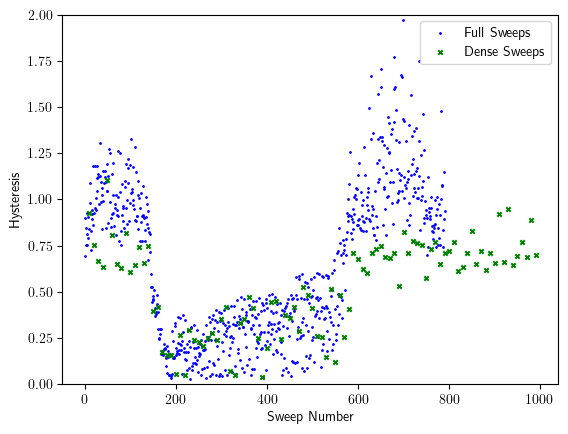

In [7]:
plt.scatter(full_nums, full_hys,c='blue', s =1)
plt.scatter(dense_nums[1:], dense_hys[1:], c = 'green',s=10,  marker='x')
plt.legend([r"Full Sweeps", r"Dense Sweeps"])
plt.xlabel(r"Sweep Number")
plt.ylabel(r"Hysteresis ")
plt.ylim([0., 2.])
print(dense_areas[0])
#plt.savefig("Hysteresis_vs_sweepnum.pdf")

Same plot, zoomed in

Text(0, 0.5, 'Hysteresis')

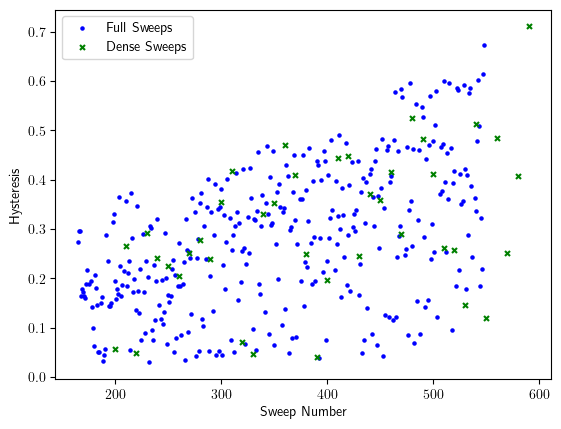

In [8]:
plt.scatter(full_nums[150:500], full_hys[150:500],c='blue', s =5)
plt.scatter(dense_nums[20:60], dense_hys[20:60], c = 'green',s=13,  marker='x')
plt.legend([r"Full Sweeps", r"Dense Sweeps"])
plt.xlabel(r"Sweep Number")
plt.ylabel(r"Hysteresis")

Area between IV curves and the full rectangle vs sweep number to check that the process looks right

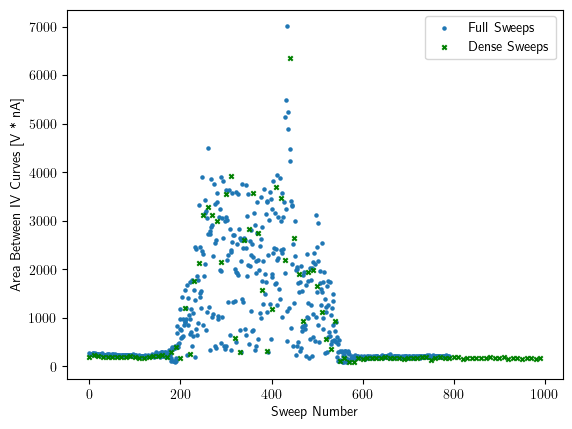

In [9]:

plt.scatter(full_nums, full_areas, s = 5)
plt.scatter(dense_nums, dense_areas,c = 'green',s=10,  marker='x')
plt.ylabel(r"Area Between IV Curves [V * nA]")
plt.xlabel(r"Sweep Number")
plt.legend([r"Full Sweeps", r"Dense Sweeps"])

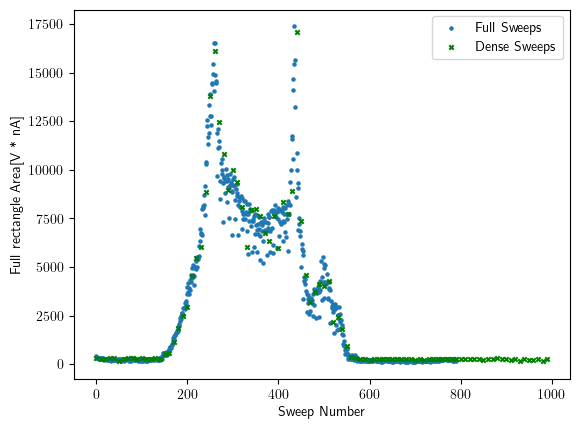

In [10]:
plt.scatter(full_nums, full_rect, s = 5)
plt.scatter(dense_nums, dense_rect, c = 'green',s=10,  marker='x')
plt.ylabel(r"Full rectangle Area[V * nA]")
plt.xlabel(r"Sweep Number")
plt.legend([r"Full Sweeps", r"Dense Sweeps"])